# Dinosaur Name Generator

## Dependencies

In [1]:
import string
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.functional import F
from torch.nn.utils.rnn import pad_sequence
from matplotlib import pyplot as plt

c:\Users\fouadhanani\miniconda3\envs\deep-learning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyper-parameters

In [2]:
batch_size = 256
n_epochs = 200
learning_rate = 0.001
hidden_size = 128
embedding_dimensions = 16
n_layers = 1
keep_prob = 0.2

## Preprocessing

Let's start by reading the dinosaur names from the `dinosaur.txt` text file.

In [3]:
with open("dinosaur.txt", "r") as file:
    names = file.read().lower().splitlines()

Now let's create a list of list of characters.

In [4]:
EOS = "EOS"

In [6]:
split_names = []
for name in names:
    split_name = list(name) + [EOS]
    split_names.append(split_name)

And now let's create a vocabulary indicies.

In [5]:
vocabulary = [EOS] + list(string.ascii_lowercase)
idx2char = dict(enumerate(vocabulary))
char2idx = {char: idx for idx, char in idx2char.items()}

In [15]:
encoded_names = []
for name in split_names:
    encoded_name = torch.tensor([char2idx[char] for char in name])
    encoded_names.append(encoded_name)

In [23]:
padded_names = pad_sequence(encoded_names, batch_first=True, padding_value=0)

## Dataset and DataLoader

In [31]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample = self.samples[index]
        X = sample[:-1]
        y = sample[1:]
        return X, y

In [32]:
dataset = Dataset(samples=padded_names)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

## Model Definition

In [6]:
class Model(nn.Module):
    def __init__(self, vocabulary_size, embedding_dimensions, hidden_size, n_layers, keep_prob):
        super(Model, self).__init__()

        self.vocabulary_size = vocabulary_size
        self.embedding_dimensions = embedding_dimensions
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.keep_prob = keep_prob

        self.embedding = nn.Embedding(num_embeddings=self.vocabulary_size, embedding_dim=self.embedding_dimensions)
        self.lstm = nn.LSTM(input_size=self.embedding_dimensions, hidden_size=self.hidden_size, num_layers=self.n_layers, batch_first=True)
        self.dropout = nn.Dropout(p=self.keep_prob)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.vocabulary_size)

    def forward(self, X, state_previous):
        h_previous, c_previous = state_previous
        embedding = self.embedding(X)
        y_hat, state_current = self.lstm(embedding, (h_previous, c_previous))
        y_hat = self.dropout(y_hat)
        y_hat = self.fc(y_hat)

        return y_hat, state_current

## Training

In [51]:
model = Model(vocabulary_size=len(char2idx), embedding_dimensions=embedding_dimensions, hidden_size=hidden_size, n_layers=n_layers, keep_prob=keep_prob)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

In [89]:
model.train()

losses = []

for epoch in range(n_epochs):
    iteration_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()

        # forward propagation
        h_previous = torch.zeros(n_layers, X.size(0), hidden_size)
        c_previous = torch.zeros(n_layers, X.size(0), hidden_size)

        y_hat, state_current = model(X, (h_previous, c_previous))

        # loss calculation
        loss = criterion(y_hat.transpose(1, 2), y)
        iteration_loss += loss.item()

        # backward propagation
        loss.backward()
        optimizer.step()

        print(f"[{epoch + 1}/{n_epochs}, {batch + 1}/{len(dataloader)}]: loss = {loss.item()}")
        
    iteration_loss /= len(dataloader)
    losses.append(iteration_loss)

[1/200, 1/7]: loss = 0.293954461812973
[1/200, 2/7]: loss = 0.2855260372161865
[1/200, 3/7]: loss = 0.2949233949184418
[1/200, 4/7]: loss = 0.2975930869579315
[1/200, 5/7]: loss = 0.30316901206970215
[1/200, 6/7]: loss = 0.3023665249347687
[1/200, 7/7]: loss = 0.30097857117652893
[2/200, 1/7]: loss = 0.282014399766922
[2/200, 2/7]: loss = 0.28387564420700073
[2/200, 3/7]: loss = 0.2986801564693451
[2/200, 4/7]: loss = 0.29626426100730896
[2/200, 5/7]: loss = 0.2904297411441803
[2/200, 6/7]: loss = 0.29116541147232056
[2/200, 7/7]: loss = 0.34009212255477905
[3/200, 1/7]: loss = 0.28534165024757385
[3/200, 2/7]: loss = 0.2910679876804352
[3/200, 3/7]: loss = 0.2917312681674957
[3/200, 4/7]: loss = 0.2900105118751526
[3/200, 5/7]: loss = 0.2940482795238495
[3/200, 6/7]: loss = 0.29527929425239563
[3/200, 7/7]: loss = 0.25871288776397705
[4/200, 1/7]: loss = 0.2911921739578247
[4/200, 2/7]: loss = 0.29365137219429016
[4/200, 3/7]: loss = 0.3045716881752014
[4/200, 4/7]: loss = 0.299922496

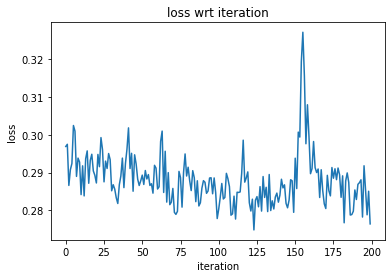

In [90]:
plt.plot(range(len(losses)), losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss wrt iteration")
plt.show()

## Saving the model

In [91]:
torch.save(model.state_dict(), "v2.pt")

## Loading the model

In [7]:
model = Model(vocabulary_size=len(char2idx), embedding_dimensions=embedding_dimensions, hidden_size=hidden_size, n_layers=n_layers, keep_prob=keep_prob)
model.load_state_dict(torch.load("main.pt"))

<All keys matched successfully>

## Sampling

Sampling using a random initial character.

In [33]:
# model.eval()
characters = []
character_idx = torch.randint(low=1, high=len(vocabulary), size=(1, 1))
characters.append(character_idx.squeeze().item())
h_previous = torch.zeros(n_layers, character_idx.size(0), hidden_size)
c_previous = torch.zeros(n_layers, character_idx.size(0), hidden_size)

with torch.no_grad():
    while character_idx.squeeze().item() != char2idx["EOS"]:
        y_hat, state_current = model(character_idx, (h_previous, c_previous))
        softmax_y_hat = F.softmax(y_hat, dim=-1)
        character_idx = torch.argmax(softmax_y_hat, dim=-1)
        characters.append(character_idx.squeeze().item())

        h_previous, c_previous = state_current


name = "".join([idx2char[character] for character in characters if character != 0])
autenticity = "real dinosaur" if name in names else "made up"
print(f"THE MODEL HAVE GENERATED THE NAME \"{name}\", WHICH IS A **{autenticity}** NAME")
if name not in names:
    with open("gen_names.txt", "a+") as file:
        file.seek(0)
        file_names = file.read().splitlines()
        if name not in file_names:
            file.seek(0, 2)
            file.write(f"{name}\n")

THE MODEL HAVE GENERATED THE NAME "walkersaurus", WHICH IS A **real dinosaur** NAME


Sampling using a pre-determined initial character.

In [82]:
# model.eval()
characters = []
initial_character = input(">> input an initial dinosaur name character: ")
character_idx = torch.tensor([[char2idx[initial_character]]])
characters.append(character_idx.squeeze().item())
h_previous = torch.zeros(n_layers, character_idx.size(0), hidden_size)
c_previous = torch.zeros(n_layers, character_idx.size(0), hidden_size)

with torch.no_grad():
    while character_idx.squeeze().item() != char2idx["EOS"]:
        y_hat, state_current = model(character_idx, (h_previous, c_previous))
        softmax_y_hat = F.softmax(y_hat, dim=-1)
        character_idx = torch.argmax(softmax_y_hat, dim=-1)
        characters.append(character_idx.squeeze().item())

        h_previous, c_previous = state_current

name = "".join([idx2char[character] for character in characters if character != 0])
autenticity = "real dinosaur" if name in names else "made up"
print(f"THE MODEL HAVE GENERATED THE NAME \"{name}\", WHICH IS A **{autenticity}** NAME")
if name not in names:
    with open("gen_names.txt", "a+") as file:
        file.seek(0)
        file_names = file.read().splitlines()
        if name not in file_names:
            file.seek(0, 2)
            file.write(f"{name}\n")

THE MODEL HAVE GENERATED THE NAME "quillesaurus", WHICH IS A **made up** NAME
